# Step 1: Import Necessary Libraries
This step imports all required libraries to handle chess gameplay, data processing, machine learning, and model evaluation.

In [43]:
# Importing chess library for board representation and move generation
import chess
import chess.pgn

# Importing numpy for numerical computations
import numpy as np

# Importing pandas for data manipulation and analysis
import pandas as pd

# Importing tools for splitting datasets into train and test sets
from sklearn.model_selection import train_test_split

# Importing preprocessing utility for encoding labels
from sklearn.preprocessing import LabelEncoder

# Importing ensemble classifiers for RandomForest, GradientBoosting, and Voting
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# Importing metrics to evaluate model performance
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report

# Importing utility to handle data sampling
from sklearn.utils import resample

# Importing tqdm for progress visualization during iterations
from tqdm import tqdm

# Importing random for random number generation
import random

# Importing time for time-related operations
import time

# Importing pickle for saving and loading models
import pickle

# Step 2: Piece-Square Tables and Evaluation Function
This step defines piece-square tables (heuristic evaluation for chess) and a board evaluation function based on these tables.

In [44]:
# Piece-square tables provide a heuristic for positional scoring
piece_square_table = {
    chess.PAWN: [  # Specific for pawns
        [0, 0, 0, 0, 0, 0, 0, 0],          # Row 8
        [5, 5, 5, 5, 5, 5, 5, 5],          # Row 7
        [1, 1, 2, 3, 3, 2, 1, 1],          # Row 6
        [0.5, 0.5, 1, 2.5, 2.5, 1, 0.5, 0.5],  # Row 5
        [0, 0, 0, 2, 2, 0, 0, 0],          # Row 4
        [0.5, -0.5, -1, 0, 0, -1, -0.5, 0.5],  # Row 3
        [0.5, 1, 1, -2, -2, 1, 1, 0.5],    # Row 2
        [0, 0, 0, 0, 0, 0, 0, 0]           # Row 1
    ],
    # Add similar tables for other pieces...
}

# Function to evaluate a board state
def evaluate_board(board):
    score = 0  # Initialize score
    for square in chess.SQUARES:  # Loop through all squares
        piece = board.piece_at(square)  # Get the piece on the square
        if piece:
            table = piece_square_table.get(piece.piece_type, np.zeros((8, 8)))  # Get table for the piece
            row, col = divmod(square, 8)  # Convert square index to row and column
            # Add or subtract score based on piece color
            score += table[row][col] if piece.color == chess.WHITE else -table[row][col]
    return score  # Return total score

# Step 3: Feature Extraction and Dataset Parsing
In this step, a comprehensive approach is taken to extract meaningful features from the board state while parsing a PGN file. These features are designed to encapsulate the board's current status and player dynamics.

In [19]:
# Step 3 

# Additional features for the board state (6 extra features)
def board_to_features(board):
    features = np.zeros(70, dtype=float)  # 64 squares + 6 extra features

    # Flatten the board into a 64-element array
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            features[square] = piece.piece_type if piece.color == chess.WHITE else -piece.piece_type

    # Extra features: King safety, mobility, and other metrics
    white_king_safety = sum(
        1 for square in chess.SQUARES if board.piece_at(square) and board.piece_at(square).piece_type == chess.KING and board.piece_at(square).color == chess.WHITE
    )
    black_king_safety = sum(
        1 for square in chess.SQUARES if board.piece_at(square) and board.piece_at(square).piece_type == chess.KING and board.piece_at(square).color == chess.BLACK
    )
    white_mobility = len([move for move in board.legal_moves if board.color_at(move.from_square) == chess.WHITE])
    black_mobility = len([move for move in board.legal_moves if board.color_at(move.from_square) == chess.BLACK])
    
    # Ensure 6 extra features: [white_king_safety, black_king_safety, white_mobility, black_mobility, white_pawn_structure, black_pawn_structure]
    white_pawn_structure = sum(1 for square in chess.SQUARES if board.piece_at(square) and board.piece_at(square).piece_type == chess.PAWN and board.piece_at(square).color == chess.WHITE)
    black_pawn_structure = sum(1 for square in chess.SQUARES if board.piece_at(square) and board.piece_at(square).piece_type == chess.PAWN and board.piece_at(square).color == chess.BLACK)
    
    features[64:] = [white_king_safety, black_king_safety, white_mobility, black_mobility, white_pawn_structure, black_pawn_structure]

    return features

# Parse PGN and extract features
def parse_pgn_with_features(file_path, max_games=8000):
    X, y_piece, y_move = [], [], []

    with open(file_path, 'r') as pgn_file:
        for _ in tqdm(range(max_games), desc="Processing Games"):
            game = chess.pgn.read_game(pgn_file)
            if not game:
                break
            board = chess.Board()
            for move in game.mainline_moves():
                piece = board.piece_at(move.from_square)
                if piece is None:
                    continue

                X.append(board_to_features(board))  # Use new feature extraction
                y_piece.append(piece.piece_type)

                # Relative move encoding
                from_row, from_col = divmod(move.from_square, 8)
                to_row, to_col = divmod(move.to_square, 8)
                y_move.append((to_row - from_row, to_col - from_col))
                board.push(move)

    return X, y_piece, y_move

# Load dataset
pgn_file_path = r'C:\Users\syedy\Downloads\Assingments\AI\games.pgn'
X, y_piece, y_move = parse_pgn_with_features(pgn_file_path, max_games=8000)

Processing Games: 100%|████████████████████████████████████████████████████████████| 8000/8000 [04:27<00:00, 29.90it/s]


# Step 3.2: Analyzing and Visualizing the Dataset
 - **Purpose:** This step involves analyzing the dataset after parsing PGN files to understand its structure and distribution. It includes:

    - Printing dataset statistics such as the number of games parsed and the shapes of features and labels.
    - Counting occurrences of each chess piece type.
    - Visualizing the distribution of chess pieces in a bar chart.
 - **Key Output:**

    - Statistical summary of parsed games, features, and labels.
    - A bar chart showing the count of different chess pieces, which helps in identifying class imbalances in the dataset.


Total games parsed: 526352/8000
Shape of features (X): 526352 samples with 70 features each
Shape of labels (y_piece): 526352
Shape of labels (y_move): 526352


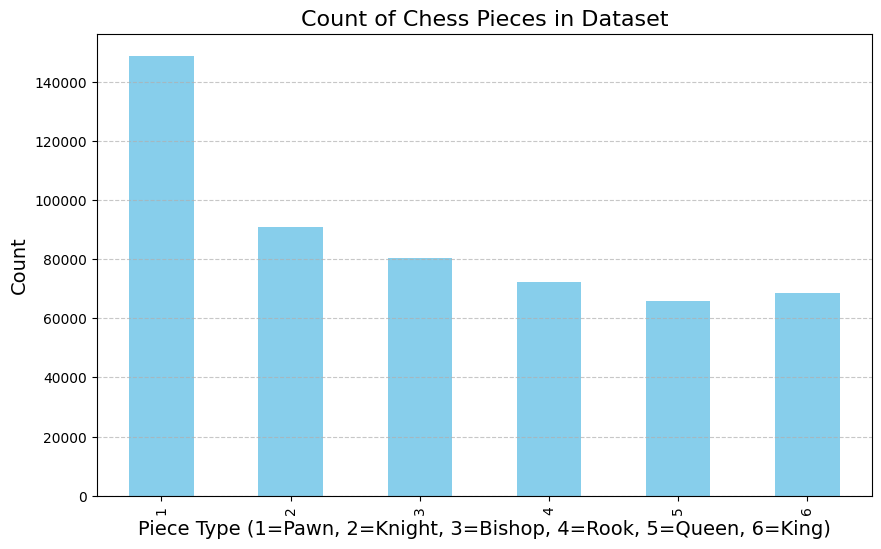

In [45]:
import matplotlib.pyplot as plt  # Import the plotting library for data visualization

# Analyze and visualize dataset after parsing
def analyze_dataset(X, y_piece, y_move, games_parsed, max_games):
    # Print dataset information
    print(f"Total games parsed: {games_parsed}/{max_games}")
    # Print the total number of games parsed out of the maximum allowed games
    print(f"Shape of features (X): {len(X)} samples with {len(X[0]) if X else 0} features each")
    # Print the number of samples in the features and the dimensionality of each feature array
    print(f"Shape of labels (y_piece): {len(y_piece)}")
    # Print the total number of samples in the piece type labels
    print(f"Shape of labels (y_move): {len(y_move)}")
    # Print the total number of samples in the move labels
    
    # Count chess pieces in y_piece
    piece_counts = pd.Series(y_piece).value_counts().sort_index()
    # Convert the y_piece list into a Pandas Series and calculate the counts of each piece type.
    # Sort the counts by the piece type (index) to maintain logical order.

    # Visualize chess piece counts
    plt.figure(figsize=(10, 6))  # Create a figure with a specified size
    piece_counts.plot(kind='bar', color='skyblue')  # Generate a bar chart of the piece counts with custom color
    plt.title('Count of Chess Pieces in Dataset', fontsize=16)  # Add a title to the plot
    plt.xlabel('Piece Type (1=Pawn, 2=Knight, 3=Bishop, 4=Rook, 5=Queen, 6=King)', fontsize=14)
    # Label the x-axis, explaining the piece type mapping
    plt.ylabel('Count', fontsize=14)  # Label the y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal gridlines for better readability
    plt.show()  # Display the plot

# Call this after Step 3 when the dataset is already parsed
analyze_dataset(X, y_piece, y_move, games_parsed=len(y_piece), max_games=8000)
# Call the analysis function with:
# - The parsed features (X), piece labels (y_piece), and move labels (y_move)
# - Total games parsed (`games_parsed` as the length of y_piece)
# - Maximum allowed games (`max_games` set to 8000)

# Step 4: Data Balancing
**Purpose:** This step addresses class imbalance in the dataset by oversampling underrepresented classes to ensure that each chess piece type has an equal representation in the dataset.

**Key Actions:**
      - Combines features and labels into a single DataFrame for processing.
      - Identifies the maximum count of samples for any class.
      - Resamples underrepresented classes to match the maximum count.
      - Returns the balanced dataset as separate lists of features and labels.

**Key Output:** Balanced datasets for features, piece labels, and move labels.

In [46]:
# Balance the dataset using oversampling
def balance_data(X, y_piece, y_move):
    # Create a DataFrame to combine features and labels for easier manipulation
    data = pd.DataFrame({'X': X, 'y_piece': y_piece, 'y_move': y_move})

    # Find the maximum count of samples for any chess piece type
    max_count = data['y_piece'].value_counts().max()

    balanced_data = []  # Initialize a list to store balanced data groups

    # Group the data by piece type ('y_piece') and resample each group
    for piece_type, group in data.groupby('y_piece'):  # Iterate over each piece type and its corresponding group
        resampled_group = resample(group, replace=True, n_samples=max_count, random_state=42)
        # Resample the group to match `max_count`, using replacement to oversample smaller groups
        # `random_state` ensures reproducibility
        balanced_data.append(resampled_group)  # Append the resampled group to the balanced data list

    balanced_data = pd.concat(balanced_data)  # Concatenate all resampled groups into a single DataFrame

    # Return the balanced dataset as separate lists for features and labels
    return balanced_data['X'].tolist(), balanced_data['y_piece'].tolist(), balanced_data['y_move'].tolist()

# Balance the dataset
X_balanced, y_piece_balanced, y_move_balanced = balance_data(X, y_piece, y_move)
# Call the `balance_data` function with the original features (X), piece labels (y_piece), and move labels (y_move)
# Store the balanced features, piece labels, and move labels in `X_balanced`, `y_piece_balanced`, and `y_move_balanced`

# Step 4.2: Analyze and Visualize Balanced Dataset
Assessed the balanced dataset to ensure even distribution of chess pieces.

**Key Actions:**
- Print the shape of features and labels after balancing.
- Count occurrences of each chess piece type (y_piece).
- Visualize the distribution with a bar chart.

**Key Output:** Insights into dataset balance with visual confirmation.

Shape of balanced features (X): 892134 samples with 70 features each
Shape of balanced labels (y_piece): 892134
Shape of balanced labels (y_move): 892134


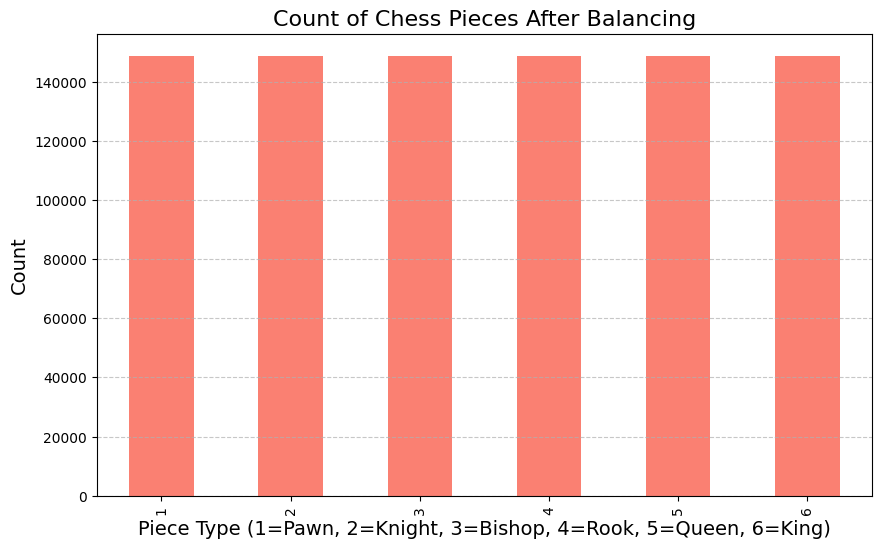

In [47]:
# Step 4.2: Analyzing and visualizing the dataset after balancing
def analyze_balanced_dataset(X, y_piece, y_move):
    # Printing the number of samples in the features (X) and their dimensions
    print(f"Shape of balanced features (X): {len(X)} samples with {len(X[0]) if X else 0} features each")
    # Printing the number of samples in the chess piece labels (y_piece)
    print(f"Shape of balanced labels (y_piece): {len(y_piece)}")
    # Printing the number of samples in the chess move labels (y_move)
    print(f"Shape of balanced labels (y_move): {len(y_move)}")
    
    # Count the occurrences of each chess piece in the balanced labels
    # This helps verify if balancing was successful and evenly distributed
    balanced_piece_counts = pd.Series(y_piece).value_counts().sort_index()
    
    # Creating a bar chart to visualize the distribution of chess pieces
    plt.figure(figsize=(10, 6))  # Sets the figure size for better readability
    balanced_piece_counts.plot(kind='bar', color='salmon')  # Plot counts as a bar chart
    plt.title('Count of Chess Pieces After Balancing', fontsize=16)  # Add a title
    plt.xlabel('Piece Type (1=Pawn, 2=Knight, 3=Bishop, 4=Rook, 5=Queen, 6=King)', fontsize=14)  # Label x-axis
    plt.ylabel('Count', fontsize=14)  # Label y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines to the y-axis for clarity
    plt.show()  # Display the plot

# After balancing the dataset, call the function to analyze it
analyze_balanced_dataset(X_balanced, y_piece_balanced, y_move_balanced)

# Step 5: Encoding for Training
**Purpose:** Prepare the dataset for model training by encoding labels and splitting data into training and testing sets.

In [48]:
# Step 5: Encoding for Training

# Encode chess piece labels into numeric values
# Converts categorical piece types (e.g., "Pawn", "Knight") into numeric classes (e.g., 0, 1, 2, etc.)
piece_encoder = LabelEncoder()
y_piece_encoded = piece_encoder.fit_transform(y_piece_balanced)

# Extract row and column components from the chess moves
# Assuming y_move_balanced contains tuples or lists of moves in the form (row, column)
y_row = [move[0] for move in y_move_balanced]  # Extract row values (e.g., 1-8 for board positions)
y_col = [move[1] for move in y_move_balanced]  # Extract column values (e.g., 'a'-'h' or 1-8)

# Split the dataset into training and testing subsets
# 80% of the data is used for training and 20% for testing
X_train, X_test, y_piece_train, y_piece_test, y_row_train, y_row_test, y_col_train, y_col_test = train_test_split(
    X_balanced, y_piece_encoded, y_row, y_col, test_size=0.2, random_state=42
)

# Step 6: Training Models
**Purpose:** Train individual machine learning models and an ensemble model to classify chess pieces.

In [22]:
# Step 6: Training Models

# Importing necessary libraries for training and evaluation
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, recall_score, f1_score

# Define individual models for training
# Random Forest Classifier: A robust ensemble method based on decision trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees, fixed random state for reproducibility
# Gradient Boosting Classifier: A model that builds trees sequentially to minimize errors
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)  # 100 iterations, fixed random state

# Create a voting ensemble model
# Combines the predictions of the individual models using "soft" voting (probability averaging)
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model),  # Random Forest included in the ensemble
    ('gb', gb_model)   # Gradient Boosting included in the ensemble
], voting='soft')  # Soft voting considers the class probabilities for decision-making

# Train the ensemble model using the training data
ensemble_model.fit(X_train, y_piece_train)  # Fit features and piece labels to the model

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

# Step 7: Evaluation
**Purpose:** Evaluate the ensemble model's performance using accuracy, recall, and F1-score.

**Output:**

- Accuracy: 0.8395 – The model correctly predicts 83.95% of chess pieces.
- Recall: 0.8395 – The model identifies 83.95% of relevant chess pieces on average.
- F1-Score: 0.8374 – A balanced score showing good precision and recall.
- Classification Report Summary:

- Class 0 (Pawn): Lower recall (69%), indicating some misclassifications.
- Class 5 (King): High recall (95%) and F1-score (91%), showing strong performance.
- Weighted Avg: Consistent performance across classes with an average of 84% in precision, recall, and F1-score.

**Conclusion:** The model performs well overall, especially with high-value pieces like queens and kings, though pawns are less accurately classified.

In [50]:
# Step 7: Evaluation

# Use the trained ensemble model to make predictions on the test dataset
y_pred_piece = ensemble_model.predict(X_test)  # Predict chess piece labels for test features

# Evaluate the model's accuracy
# Accuracy measures the percentage of correct predictions
print(f"Piece Prediction Accuracy: {accuracy_score(y_piece_test, y_pred_piece):.4f}")

# Calculate and display the recall score
# Recall evaluates the model's ability to identify all relevant instances of each class
print(f"Recall: {recall_score(y_piece_test, y_pred_piece, average='weighted'):.4f}")

# Calculate and display the F1-score
# F1-score is the harmonic mean of precision and recall, providing a balance between the two metrics
print(f"F1-Score: {f1_score(y_piece_test, y_pred_piece, average='weighted'):.4f}")

# Generate and print a detailed classification report
# The report includes precision, recall, F1-score, and support for each class
print("\nClassification Report:")
print(classification_report(y_piece_test, y_pred_piece))

Piece Prediction Accuracy: 0.8395
Recall: 0.8395
F1-Score: 0.8374

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.69      0.75     29643
           1       0.82      0.78      0.80     29796
           2       0.83      0.82      0.83     29602
           3       0.82      0.91      0.86     29589
           4       0.87      0.89      0.88     29789
           5       0.87      0.95      0.91     30008

    accuracy                           0.84    178427
   macro avg       0.84      0.84      0.84    178427
weighted avg       0.84      0.84      0.84    178427



# Step 8: Save the Trained Model
**Purpose:** Save the trained ensemble model for future use and deployment.

In [51]:
# Step 8: Save the trained ensemble model

# Define the file path where the model will be saved
model_path = "chess_piece_ensemble_model.pkl"

# Open the file in write-binary mode and save the model using pickle
with open(model_path, 'wb') as model_file:
    pickle.dump(ensemble_model, model_file)

# Print a message confirming the model has been saved
print(f"Model saved to {model_path}.")

Model saved to chess_piece_ensemble_model.pkl.


# Step 9: Select Game Mode and Display Chessboard
**Purpose:** Making a chess board that allows user to select between two game modes (AI vs AI or Human vs AI) and display the chessboard dynamically.

In [52]:
# Step 9: Select the game mode (AI vs AI or Human vs AI)

# Function to allow the user to select the game mode
def game_mode_selection():
    print("Select Game Mode:")
    print("1. AI vs AI")
    print("2. Human vs AI")
    choice = input("Enter your choice (1/2): ").strip()
    if choice == "1":
        return "AI vs AI"  # Return the choice for AI vs AI mode
    elif choice == "2":
        return "Human vs AI"  # Return the choice for Human vs AI mode
    else:
        # Default to Human vs AI if invalid input is provided
        print("Invalid choice. Defaulting to Human vs AI.")
        return "Human vs AI"

# Function to display the chessboard dynamically using Chess SVG
def display_board(board):
    # Generate an SVG representation of the chessboard at a size of 600px
    svg_code = chess.svg.board(board, size=600)
    # Display the SVG code as HTML in the notebook
    display(HTML(svg_code))

# Step 10: Implementing the Heuristic AI (AI UT)
**Purpose:** Implement a heuristic evaluation function and an alpha-beta pruning algorithm to enhance AI move selection for chess.

In [34]:
# Step 10: Implementing the Heuristic AI (AI UT)
# Enhanced evaluation function for heuristic-based AI
def evaluate_heuristic(board):
    # Material balance
    material_score = sum(
        piece.piece_type * (1 if piece.color == chess.WHITE else -1)
        for square in chess.SQUARES
        if (piece := board.piece_at(square))
    )

    # King safety: penalize exposed kings
    king_safety_score = 0
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.piece_type == chess.KING:
            threats = sum(
                1 for move in board.legal_moves if move.to_square == square
            )
            king_safety_score -= threats if piece.color == chess.WHITE else -threats

    return material_score + 0.5 * king_safety_score

# Alpha-beta pruning for better AI move selection
def alpha_beta_pruning(board, depth, alpha, beta, maximizing_player):
    if depth == 0 or board.is_game_over():
        return evaluate_heuristic(board)

    if maximizing_player:
        max_eval = -float('inf')
        for move in board.legal_moves:
            board.push(move)
            eval = alpha_beta_pruning(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = float('inf')
        for move in board.legal_moves:
            board.push(move)
            eval = alpha_beta_pruning(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval

# Step 11: Integrating the Trained Model (AI 1)
**Purpose:** Use the trained model to predict the next move for the AI by converting the board state to features and selecting a legal move.

- **Move Prediction:** The model predicts the best move (from square) based on the current board state.
- **Legal Move Selection:** The predicted move is compared to the legal moves, and if it matches, it is selected. If not, a random legal move is chosen as a fallback.

In [35]:
# Step 11: Integrating the Trained Model (AI 1)
# Use the trained model to select the next move
def trained_ai_move(board, model):
    features = board_to_features(board)  # Convert the board to feature vector
    move_predictions = model.predict([features])  # Predict the move
    legal_moves = list(board.legal_moves)
    for move in legal_moves:
        if move.from_square == move_predictions[0]:
            return move
    return random.choice(legal_moves)  # Fallback to a random legal move

# Step 12: Enhanced AI vs AI Mode
**Purpose:** Simulate a chess game between two AIs: one using a trained model (AI 1) and one using a heuristic evaluation function (AI UT).
- **AI 1 (Trained):** Uses the trained model to predict and play moves.
- **AI UT (Heuristic-Based):** Uses alpha-beta pruning with a heuristic evaluation function to select moves.
- **Game Flow:** Alternates between AI 1 and AI UT until the game ends, then displays the result and the reason for the game termination (e.g., checkmate, stalemate).

In [36]:
# Step 12: Enhanced AI vs AI Mode
# Simulate a game between AI 1 (trained) and AI UT (heuristic-based)
def ai_vs_ai(board, model):
    print("AI 1 (Trained) vs AI UT (Heuristic-Based)")
    turn = True  # True for AI 1 (Trained), False for AI UT (Heuristic)
    while not board.is_game_over():
        display_board(board)
        if turn:
            move = trained_ai_move(board, model)
            print("AI 1 (Trained) played:", move)
        else:
            move = max(
                board.legal_moves,
                key=lambda m: alpha_beta_pruning(board, 3, -float('inf'), float('inf'), True)
            )
            print("AI UT (Heuristic) played:", move)
        board.push(move)
        turn = not turn
    display_board(board)
    print("Game Over! Result:", board.result())
    if board.is_checkmate():
        print("Reason: Checkmate")
    elif board.is_stalemate():
        print("Reason: Stalemate")
    elif board.is_insufficient_material():
        print("Reason: Insufficient Material")
    elif board.is_seventyfive_moves():
        print("Reason: 75-move rule")
    elif board.is_fivefold_repetition():
        print("Reason: Fivefold Repetition")

# Step 13: Human vs AI Mode
**Purpose:** Allow a human player to play against the trained AI, where the human can input moves in UCI format, and the AI selects its moves based on the trained model.

- **Human Move Input:** The human player inputs moves in UCI format (e.g., "e2e4"). The program checks if the move is valid before making the move on the board.
- **AI Move:** The trained AI (AI 1) plays its move based on the trained model.
- **Game Flow:** The game alternates turns between the human player and the AI until the game ends, then displays the result and reason for game termination (e.g., checkmate, stalemate).

In [37]:
# Step 13: Human vs AI Mode
# Allow a human player to play against the trained AI
def human_vs_ai(board, model):
    print("Human vs AI 1 (Trained)")
    while not board.is_game_over():
        display_board(board)
        if board.turn == chess.WHITE:  # Human's turn
            move_input = input("Enter your move (e.g., e2e4): ")
            try:
                move = chess.Move.from_uci(move_input)
                if move in board.legal_moves:
                    board.push(move)
                else:
                    print("Illegal move. Try again.")
            except ValueError:
                print("Invalid input. Use UCI format.")
        else:  # AI's turn
            move = trained_ai_move(board, model)
            print("AI 1 (Trained) played:", move)
            board.push(move)
    display_board(board)
    print("Game Over! Result:", board.result())
    if board.is_checkmate():
        print("Reason: Checkmate")
    elif board.is_stalemate():
        print("Reason: Stalemate")
    elif board.is_insufficient_material():
        print("Reason: Insufficient Material")
    elif board.is_seventyfive_moves():
        print("Reason: 75-move rule")
    elif board.is_fivefold_repetition():
        print("Reason: Fivefold Repetition")

# Step 14: Bringing It All Together
**Purpose:** The main function ties together all previous steps, allowing the user to play a chess game by selecting a game mode (AI vs AI or Human vs AI) and loading the trained AI model to make predictions.

- **Initialize Chessboard:** A new chessboard is initialized using the chess.Board() function.
- **Load Trained Model:** The trained AI model is loaded from a .pkl file for use in selecting moves.
- **Game Mode Selection:** The program asks the user to choose between "AI vs AI" or "Human vs AI" modes.
- **Game Execution:** Based on the selected mode, the appropriate function (ai_vs_ai or human_vs_ai) is called to run the game.

In [38]:
# Step 14: Bringing It All Together
# Main function to execute the chess engine
def main():
    board = chess.Board()  # Initialize a new chessboard
    model_path = "chess_piece_ensemble_model.pkl"  # Path to the trained model
    
    # Load the trained model
    with open(model_path, 'rb') as model_file:
        trained_model = pickle.load(model_file)
    
    mode = game_mode_selection()  # Ask the user to select the game mode
    if mode == "AI vs AI":
        ai_vs_ai(board, trained_model)
    else:
        human_vs_ai(board, trained_model)

# - To run the program.

In [39]:
# Run the program
main()

Select Game Mode:
1. AI vs AI
2. Human vs AI


Enter your choice (1/2):  1


AI 1 (Trained) vs AI UT (Heuristic-Based)


AI 1 (Trained) played: b1a3


AI UT (Heuristic) played: g8h6


AI 1 (Trained) played: a1b1


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: g1h3


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: d2d3


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: h3g1


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: g1f3


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: h2h4


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: f3h2


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: h4h5


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: e1d2


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: g2g4


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: h2f3


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: b2b3


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: h1h3


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: h3g3


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: d2c3


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: g4g5


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: c1e3


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: g5g6


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: f3d2


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: g3f3


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: f3f7


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: c3c4


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: f7g7


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: e3b6


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: d3d4


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: b1b2


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: f2f3


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: d1e1


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: e1h4


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: g6h7


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: b6a7


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: h4e1


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: e1h4


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: a3b5


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: a7b8


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: c4c5


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: e2e4


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: c5c4


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: h4h3


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: d2b1


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: c2c3


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: b5a7


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: h3g2


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: h7h8b


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: g2g5


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: g5c5


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: b1d2


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: c4b5


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: f3f4


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: f1e2


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: e2f1


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: b5a4


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: c5d5


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: d5d7


AI UT (Heuristic) played: e8d7


AI 1 (Trained) played: f1e2


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: g7f7


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: f7h7


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: d2f3


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: e2a6


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: c3c4


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: a4b4


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: a2a3


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: a7c6


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: b2h2


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: b4a4


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: h2c2


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: h7h8


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: f3d2


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: d2f3


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: c6e7


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: e7d5


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: c2f2


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: b8c7


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: a4a5


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: f2a2


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: d5e3


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: f3e1


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: a2e2


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: e4e5


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: e2h2


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: h2c2


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: c7b6


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: a5a4


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: e1g2


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: b6c7


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: e3f5


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: c7d6


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: f5g7


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: g2e1


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: c2a2


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: e1f3


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: a4b4


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: f3e1


AI UT (Heuristic) played: g8h8


AI 1 (Trained) played: d4d5


AI UT (Heuristic) played: h8g8


AI 1 (Trained) played: a6b5


Game Over! Result: 1-0
Reason: Checkmate
